### Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.io import read_image
from torch.optim import Adam
import torchvision.transforms as transforms

from collections import OrderedDict
import os
import json

### Hyperparameters  
* $x$ is a observed variable in dataset $X=\{x^{(i)}\}^N_{i=1}$ consisting of $N$ i.i.d. samples, $x\in\mathbb{R^{\text{x\_dim}}}$  
* $z$ is a latent variable, $z\in\mathbb{R^{\text{z\_dim}}}$ such that $z{\sim}q_{\phi}(z|x)$

In [3]:
annotations_file_train = "./data/train/labels.csv"
img_dir_train = "./data/train/images/"
annotations_file_test = "./data/test/labels.csv"
img_dir_test = "./data/test/images/"

device = "cuda" if torch.cuda.is_available() else "cpu"
workers = 1
learning_rate = 1E-4
batch_size = 50
epochs = 30
# x_dim = 784 is defined by dataset
z_dim = 64
hidden_dim = 256

vae_state_dict = "./runs/9734404/vae-state-dict.pt"

### Class definitions

In [4]:
class MNISTDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file) 
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = torch.flatten(read_image(img_path)).float() / 255.0
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
    
class Encoder(nn.Module):
    def __init__(self, x_dim, hidden_dim, z_dim):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(x_dim, hidden_dim)
        self.mu = nn.Linear(hidden_dim, z_dim)
        self.log_sigma = nn.Linear(hidden_dim, z_dim)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, x):
        h = self.leaky_relu(self.linear1(x))
        mean = self.mu(h)
        log_var = self.log_sigma(h)
        return mean, log_var
    
class Decoder(nn.Module):
    def __init__(self, z_dim, hidden_dim, x_dim):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(z_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, x_dim)
        self.leaky_relu = nn.LeakyReLU()

    def forward(self, z):
        h = self.leaky_relu(self.linear1(z))
        x_hat = torch.sigmoid(self.output(h))
        return x_hat
    
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterise(self, mean, var):
        epsilon = torch.randn_like(var)
        z = mean + var * epsilon
        return z
    
    def forward(self, x):
        mean, log_var = self.encoder(x)
        z = self.reparameterise(mean, torch.exp(0.5 * log_var))
        x_hat = self.decoder(z)
        return x_hat, mean, log_var
    
def loss_function(x, x_hat, mean, log_var):
    reconstruction_error = nn.functional.binary_cross_entropy(x_hat, x, reduction="sum")
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    return kl_divergence + reconstruction_error

### Training

In [14]:
dataset_train = MNISTDataset(annotations_file_train, img_dir_train)
loader_train = DataLoader(Subset(dataset_train, range(10)), batch_size=batch_size, shuffle=True, num_workers=workers)

x_dim = len(dataset_train[0][0])
encoder = Encoder(x_dim, hidden_dim, z_dim)
decoder = Decoder(z_dim, hidden_dim, x_dim)
vae = VAE(encoder, decoder)
vae.to(device)
optimiser = Adam(vae.parameters(), lr=learning_rate)

In [ ]:
print("Training VAE...")
vae.train()
i = 1
curr_loss = None
for epoch in range(epochs):
    total_loss = 0
    print(f"Epoch {i}:")
    for batch in tqdm(loader_train):
        optimiser.zero_grad()
        x = batch[0]
        x.to(device)
        x_hat, mean, log_var = vae(x)
        loss = loss_function(x, x_hat, mean, log_var)
        total_loss += loss.item()
        loss.backward()
        optimiser.step()
    print(f"Epoch {i} complete.\tAverage loss: {total_loss / batch_size}")
    i += 1
    curr_loss = total_loss
print("Traning complete.")

In [16]:
hyperparameters = OrderedDict([
    ("annotations_file_train", annotations_file_train),
    ("img_dir_train", img_dir_train),
    ("annotations_file_test", annotations_file_test),
    ("img_dir_test", img_dir_test),
    ("device", device),
    ("workers", workers),
    ("learning_rate", learning_rate),
    ("batch_size", batch_size),
    ("epochs", epochs),
    ("z_dim", z_dim),
    ("hidden_dim", hidden_dim)
])
log = {
    "hyperparameters": hyperparameters,
    "loss": curr_loss
}
torch.save(vae.state_dict(), "vae-state-dict.pt")
torch.save(optimiser.state_dict(), "optimiser-state-dict.pt")
with open("log.json", 'w') as fp:
    json.dump(log, fp)

### Evaluation

In [ ]:
dataset_test = MNISTDataset(annotations_file_test, img_dir_test)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=workers)

x_dim = len(dataset_test[0][0])

encoder = Encoder(x_dim, hidden_dim, z_dim)
decoder = Decoder(z_dim, hidden_dim, x_dim)
vae = VAE(encoder, decoder)
vae.load_state_dict(torch.load(vae_state_dict, weights_only=True, map_location=torch.device(device)))
vae.to(device)
vae.eval()

def plot_x(x):
    with torch.no_grad():
        x_hat, mean, log_var = vae(x.to(device))
        x_img = x.view(28, 28).cpu().numpy()
        x_hat_img = x_hat.view(28, 28).cpu().numpy()
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(x_img, cmap="gray")
        ax[1].imshow(x_hat_img, cmap="gray")
        plt.show()
    return vae.reparameterise(mean, torch.exp(0.5 * log_var)), x_hat

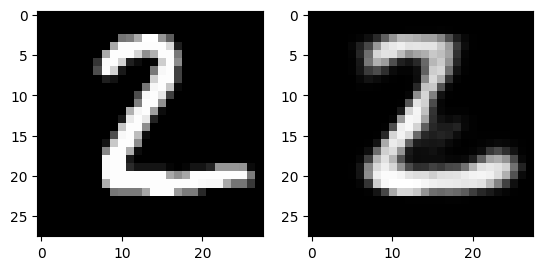

Label: 2, z: tensor([-0.5861,  1.6703, -0.8516, -0.3556,  1.3742, -0.7630,  0.4026, -1.0211,
        -0.2800,  1.3085,  0.4561,  1.1487, -1.3756,  0.2778, -2.0832, -1.7853,
        -0.8043,  0.8610, -0.5032, -0.3289,  1.3293, -0.1847,  1.4870,  0.6742,
         0.9160, -1.3614,  1.3930, -0.0055, -1.6282,  1.2602,  1.9260,  0.2557,
        -0.7608,  0.2578,  1.3899,  2.1030, -0.6755, -0.5984, -1.0903, -0.3788,
        -0.2039, -0.6817,  0.7486,  0.3669,  0.0345,  0.6307, -0.7546, -0.6393,
        -0.4803,  1.7081, -0.2475,  0.0188, -0.2202, -0.5375,  0.8984,  0.1013,
         2.1330, -1.2160,  1.8097, -0.6275,  1.5202, -0.0366, -0.3993,  2.0004],
       device='cuda:0')


In [26]:
idx = 0
z, x_hat = plot_x(dataset_test[idx][0])
print(f"Label: {dataset_test[idx][1]}, z: {z}")